In [1]:
import numpy as np 
import pandas as pd 
import os

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Compose, Resize, CenterCrop, Normalize

import glob
import random
import zipfile
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
SEED = 42

def set_seed(seed: int):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(SEED)

In [4]:
glob.glob("/kaggle/input/paddy-disease-classification/*")

['/kaggle/input/paddy-disease-classification/sample_submission.csv',
 '/kaggle/input/paddy-disease-classification/train_images',
 '/kaggle/input/paddy-disease-classification/train.csv',
 '/kaggle/input/paddy-disease-classification/test_images']

In [5]:
set_seed(SEED)

train_val_images = glob.glob("/kaggle/input/paddy-disease-classification/train_images/*/*")
test_images = glob.glob("/kaggle/input/paddy-disease-classification/test_images/*")


def train_val_split(images_list, train_size):
    n = int(len(images_list) * train_size)
    train_list = images_list[:n]
    val_list = images_list[n:]
    return train_list, val_list

random.shuffle(train_val_images)
train_images, val_images = train_val_split(train_val_images, train_size=0.9)

print(len(train_images), len(val_images), len(test_images))

train_images[:2], val_images[:2], test_images[:2]

9366 1041 3469


(['/kaggle/input/paddy-disease-classification/train_images/bacterial_leaf_blight/102639.jpg',
  '/kaggle/input/paddy-disease-classification/train_images/brown_spot/100062.jpg'],
 ['/kaggle/input/paddy-disease-classification/train_images/bacterial_leaf_blight/108844.jpg',
  '/kaggle/input/paddy-disease-classification/train_images/hispa/104182.jpg'],
 ['/kaggle/input/paddy-disease-classification/test_images/200607.jpg',
  '/kaggle/input/paddy-disease-classification/test_images/202733.jpg'])

In [6]:
transform = Compose([
    CenterCrop(446),
    Resize((256, 256)),
    ToTensor(),
    Normalize([0.4965, 0.5858, 0.2238], [0.2222, 0.2218, 0.1968])
])

In [7]:
target_names = [st.split("/")[-1] for st in glob.glob("/kaggle/input/paddy-disease-classification/train_images/*")]
target_names.sort()
target_names

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [8]:
target_2_int = {}
counter = 0
for _ in target_names:
    target_2_int[_] = counter
    counter += 1

target_2_int

{'bacterial_leaf_blight': 0,
 'bacterial_leaf_streak': 1,
 'bacterial_panicle_blight': 2,
 'blast': 3,
 'brown_spot': 4,
 'dead_heart': 5,
 'downy_mildew': 6,
 'hispa': 7,
 'normal': 8,
 'tungro': 9}

In [9]:
int_2_target = {i:t for t, i in target_2_int.items()}

int_2_target

{0: 'bacterial_leaf_blight',
 1: 'bacterial_leaf_streak',
 2: 'bacterial_panicle_blight',
 3: 'blast',
 4: 'brown_spot',
 5: 'dead_heart',
 6: 'downy_mildew',
 7: 'hispa',
 8: 'normal',
 9: 'tungro'}

In [10]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, train=True):
        self.img_dir = img_dir
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.img_dir)

    def __getitem__(self, idx):
        img_path = self.img_dir[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        if self.train:
            label = img_path.split("/")[-2]
            label = target_2_int[label]
        else:
            label = img_path.split("/")[-1].split(".")[0]
        
        label = int(label)
        return image, label

In [11]:
# class LimitDataset(Dataset):
#     def __init__(self, dataset, n):
#         self.dataset = dataset
#         self.n = n

#     def __len__(self):
#         return self.n

#     def __getitem__(self, i):
#         return self.dataset[i]

# train_images = LimitDataset(train_images, n=500)
# val_images = LimitDataset(val_images, n=500)

# test_images = LimitDataset(test_images, n=500)

In [12]:
training_data = ImageDataset(train_images, transform, train=True)
val_data = ImageDataset(val_images, transform, train=True)

test_data = ImageDataset(test_images, transform, train=False)

In [13]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=False)

test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)

In [14]:
for x, y in train_dataloader:
    print(x.shape)
    print(y)
    break

torch.Size([32, 3, 256, 256])
tensor([0, 4, 5, 5, 8, 8, 2, 4, 5, 7, 8, 0, 3, 7, 7, 5, 9, 4, 5, 9, 6, 9, 6, 7,
        6, 0, 9, 3, 6, 7, 3, 7])


In [15]:
for x, y in val_dataloader:
    print(x.shape)
    print(y)
    break

torch.Size([32, 3, 256, 256])
tensor([0, 7, 8, 3, 3, 4, 9, 3, 9, 9, 4, 6, 8, 7, 2, 8, 7, 2, 4, 0, 7, 9, 5, 8,
        3, 3, 5, 3, 7, 3, 3, 2])


In [16]:
for x, y in test_dataloader:
    print(x.shape)
    print(y)
    break

torch.Size([1, 3, 256, 256])
tensor([200607])


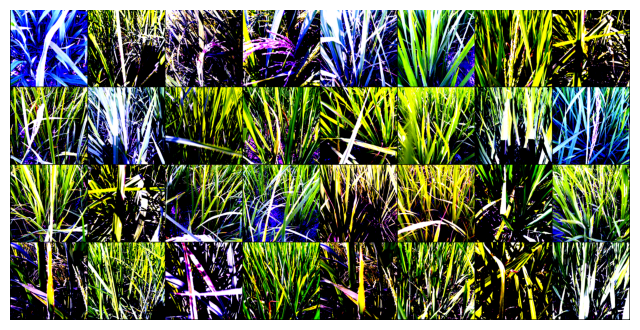

In [17]:
fig = plt.figure(figsize=(8, 8))
img = make_grid(next(iter(train_dataloader))[0], nrow=8)
img = np.transpose(img, (1, 2, 0))
plt.imshow(img)
plt.axis("off")
plt.show()

In [18]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available()else "cpu"
print(f"Using {device} device")

Using cuda device


In [19]:
# def get_mean_and_std(dataloader):
#     channels_sum, channels_squared_sum, num_batches = 0, 0, 0
#     for data, _ in dataloader:
#         # Mean over batch, height and width, but not over the channels
#         channels_sum += torch.mean(data, dim=[0,2,3])
#         channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
#         num_batches += 1
    
#     mean = channels_sum / num_batches

#     # std = sqrt(E[X^2] - (E[X])^2)
#     std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

#     return mean, std


# get_mean_and_std(train_dataloader)

In [20]:
set_seed(SEED)

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
model.fc = nn.Linear(512, 10)
model.to(device);

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [22]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0.0
    running_corrects = 0
    losses = []
    accuracies = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate running loss and accuracy
        running_loss += loss.item() * X.size(0)
        running_corrects += torch.sum(torch.argmax(pred, dim=1) == y)
        
        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    # Calculate epoch loss and accuracy
    epoch_loss = running_loss / size
    epoch_acc = running_corrects.double() / size
    losses.append(epoch_loss)
    accuracies.append(epoch_acc)
    
    return losses, accuracies

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [24]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    # Calculate epoch loss and accuracy
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return test_loss, correct

# Test Function 

In [25]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [26]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    # Train the model on the training set
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    # Test the model on the validation set
    val_loss, val_acc = test(val_dataloader, model, loss_fn)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

Epoch 1
-------------------------------
loss: 2.687675  [   32/ 9366]
loss: 2.007999  [  352/ 9366]
loss: 1.677332  [  672/ 9366]
loss: 0.871881  [  992/ 9366]
loss: 0.836422  [ 1312/ 9366]
loss: 0.776591  [ 1632/ 9366]
loss: 0.778978  [ 1952/ 9366]
loss: 0.579111  [ 2272/ 9366]
loss: 0.643559  [ 2592/ 9366]
loss: 0.609559  [ 2912/ 9366]
loss: 0.464178  [ 3232/ 9366]
loss: 0.575791  [ 3552/ 9366]
loss: 0.461025  [ 3872/ 9366]
loss: 0.361491  [ 4192/ 9366]
loss: 0.324997  [ 4512/ 9366]
loss: 0.446947  [ 4832/ 9366]
loss: 0.812405  [ 5152/ 9366]
loss: 0.632872  [ 5472/ 9366]
loss: 0.428605  [ 5792/ 9366]
loss: 0.534455  [ 6112/ 9366]
loss: 0.283869  [ 6432/ 9366]
loss: 0.424215  [ 6752/ 9366]
loss: 0.378221  [ 7072/ 9366]
loss: 0.173233  [ 7392/ 9366]
loss: 0.354825  [ 7712/ 9366]
loss: 0.373818  [ 8032/ 9366]
loss: 0.306090  [ 8352/ 9366]
loss: 0.456549  [ 8672/ 9366]
loss: 0.363533  [ 8992/ 9366]
loss: 0.490066  [ 9312/ 9366]
Test Error: 
 Accuracy: 93.9%, Avg loss: 0.203975 

Epoch 2


In [27]:
for i in train_losses:
    print(train_losses)
print('------------------------------------------------')
for i in train_accs:
    print(train_accs)
print('------------------------------------------------')

for i in val_losses:
    print(val_losses)
print('------------------------------------------------')

for i in val_accs:
    print(val_accs)
print('------------------------------------------------')


[[0.6178616567373836], [0.08537070130117551], [0.03235213672724349], [0.022238267721067743], [0.012719390364506979], [0.05908879238619729], [0.13389591075608853], [0.021947869809554023], [0.0092894902614212], [0.003362641615915217]]
[[0.6178616567373836], [0.08537070130117551], [0.03235213672724349], [0.022238267721067743], [0.012719390364506979], [0.05908879238619729], [0.13389591075608853], [0.021947869809554023], [0.0092894902614212], [0.003362641615915217]]
[[0.6178616567373836], [0.08537070130117551], [0.03235213672724349], [0.022238267721067743], [0.012719390364506979], [0.05908879238619729], [0.13389591075608853], [0.021947869809554023], [0.0092894902614212], [0.003362641615915217]]
[[0.6178616567373836], [0.08537070130117551], [0.03235213672724349], [0.022238267721067743], [0.012719390364506979], [0.05908879238619729], [0.13389591075608853], [0.021947869809554023], [0.0092894902614212], [0.003362641615915217]]
[[0.6178616567373836], [0.08537070130117551], [0.03235213672724349],

In [28]:
#for i in train_accs:
#float_list = [tensor[0].item() for tensor in train_accs]
#print(float_list)

float_list = []
for tensor in train_accs:
    float_value = float(tensor[0])
    float_list.append(float_value)

In [29]:
print(float_list)

[0.8063207345718556, 0.9784326286568439, 0.9922058509502455, 0.9951953875720692, 0.9970104633781763, 0.9820627802690582, 0.9565449498184924, 0.9945547725816783, 0.9981849241938928, 0.9990390775144138]


# **Evaluation**

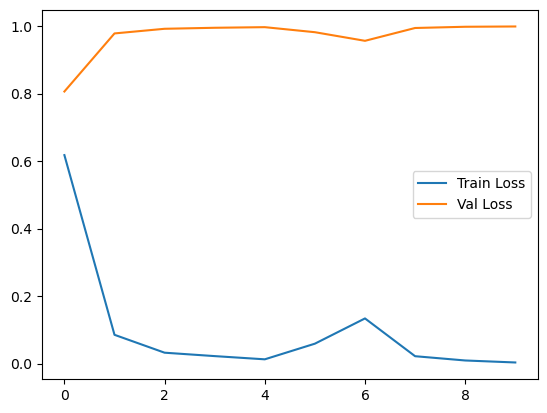

In [30]:

# print(f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}")
# print(f"Val Loss: {val_losses[-1].cpu():.4f}, Val Acc: {val_accs[-1].cpu():.4f}")

# # Plot loss and accuracy curves
# plt.plot(test_loss, label='Train Loss')
# plt.plot(correct.cpu(), label='Val Loss')
# plt.plot(train_accs, label='Train Acc')
# plt.plot(val_accs.cpu(), label='Val Acc')
# plt.legend()
# plt.show()
# print(f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}")
# print(f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")
    
#Plot loss and accuracy curves
plt.plot(train_losses ,label='Train Loss')
plt.plot(float_list, label='Val Loss')
plt.legend()
plt.show()



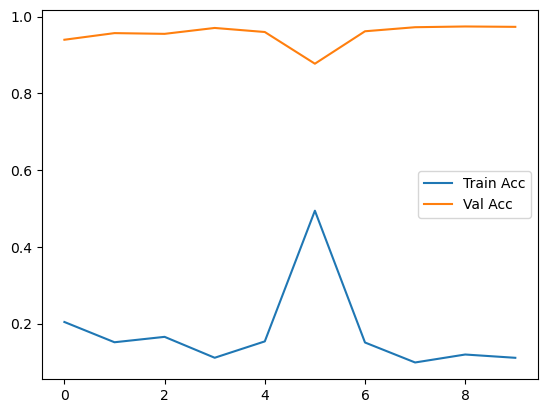

In [31]:
plt.plot(val_losses, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.show()

In [32]:
test_label = np.zeros((len(test_dataloader.dataset,)), dtype=object)
test_id = np.zeros((len(test_dataloader.dataset,)), dtype=object)


for i, (X, y) in enumerate(test_dataloader):
    X = X.to(device)
    model.eval()
    pred = model(X)
    test_label[i] = int_2_target[torch.argmax(pred, dim=1).item()]
    test_id[i] = str(y.item()) + ".jpg"

In [33]:
sub_df = pd.DataFrame({"image_id": test_id, "label": test_label})

In [34]:
sub_df.head()

,image_id,label
0,200607.jpg,normal
1,202733.jpg,normal
2,200207.jpg,bacterial_leaf_streak
3,203024.jpg,tungro
4,203056.jpg,hispa


In [35]:
#sub_df.to_csv("submission.csv", index=False)

In [36]:
# Save the PyTorch model
if not os.path.exists('./models/'):
    os.mkdir('./models/')
PATH = './models/model.pt'
torch.save(model.state_dict(), PATH)

In [37]:
# Export the PyTorch model to ONNX format
example_input = torch.randn(1, 3, 224, 224).to(device)
ONNX_PATH = './models/model.onnx'
torch.onnx.export(model, example_input, ONNX_PATH, input_names=["input"], output_names=["output"])


In [38]:
pip install onnx-tf


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 8.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [39]:
# Convert the ONNX model to TensorFlow GraphDef format
import onnx
from onnx_tf.backend import prepare
model_onnx = onnx.load(ONNX_PATH)
tf_rep = prepare(model_onnx)
TF_PATH = './models/model.pb'
tf_rep.export_graph(TF_PATH)